# Neural networks and backpropagation

In this module you will implement the backpropagation algorithm and use it to train neural networks on a couple of datasets. 

In the last module you learned how to generalize logistic regression for multiple outputs. Then you learned how to combine these generalized logistic regression units into a neural network. You've used the neural network to simulate logic gates and to recognize handwritten digits. 

In the last part of the module you saw how to train a single generalized logistic unit, which was very similar to training with logistics regression. The main part that you didn't implement was the training of a full neural network. This is the subject of this module. 

This requires two adaptations to what we've done last time. First we will need to revisit the equations for computing the gradients. It turns out that they are slightly different from what we saw last module. Second, you'll have to implement the backpropagation algorithm, that propagates the gradients back through the neural network.

This module consists of four parts:

0. We will start with a brief recap of the elements from last module on which we're going to continue to build. 
1. First you will adapt the LogisticLayer-class to use the revised equations for a logistic layer of a neural network.
2. Then you will extend the NN-class to implement the backpropagation algorithm.
3. Then you will train different neural networks on several datasets.

## Part 0: Recap

Let's start by looking back at last module. Last module discussed some concepts that we will expand on in this module.

### Generalized logistic regression

Last module we saw how neural networks can be built out of logistic regression modules. We called such a module a `LogisticLayer`. 

#### Computational graph

You saw how to represent the logistic layer as a computational graph. This graph is a convenient visualization of the mathematics that make up a logistic layer.

<img src="src/cg08_2.svg" width="30%">

#### Forward 


The method `forward` of `LogisticLayer` implemented the prediction step using the same maths as for logistic regression, but generalized for more than one output:

$$
\begin{align}
Z = A \cdot W^T \oplus b &&
A_{\mathrm{next}} = g(Z)
\end{align}
$$


#### Backward

The method `backward` implemented the computation of the gradients of the `LogisticLayer`, using the equations below. **These are only correct for a single layer network!**

$$
\begin{align}
\frac{\partial l}{\partial W} = (\hat{Y} - Y)^T \cdot X &&
\frac{\partial l}{\partial b} = \sum_{i=1}^m (\hat{Y} - Y)^{\mathrm{row} = i}
\end{align}
$$

Where, since there is only one layer, $X = A$ and $\hat{Y} = A_{\mathrm{next}}$. This module we will expand this set of equations to also work in the case of multi-layer networks.

> Note that the computational graphs are often defined for single samples (i.e., lowercase `x`) whereas the equations are all given for multiple samples (i.e., uppercase `X`). This is to, on the one hand, conform to the description of computational graphs in descriptions of neural networks that you'll find elsewhere and, on the other hand, to provide you with equations that you can directly implement.

### Neural network (without learning)

The class `NN` implemented a fully connected neural network. We worked out the forward pass for a neural network. We did not implement the backward pass for a multi-layer network yet. That will be the task for this module.

The class `NN` used a series of `LogisticLayer` modules to build up the network. This way the `NN` class itself contains very little mathematics, most of that is delegated to the `LogisticLayer` class. Providing a clean, modular design.

#### Computational graph

The computational graph of the forward pass of the $L$ layer neural network shows how the neural network is essentially $L$ logistic layers chained together. The output of logistic layer $i$ is the input of logistic layer $i+1$, and so the final output of layer $L$ depends on all the weight matrices $W_{1}$ to $W_{L}$ and all the bias terms $b_1$ to $b_L$ preceding it.

<img src="src/cg07.svg" width="100%">


#### Forward

We implemented the `forward` method by iterating over all the logistic layers, calling the `forward` method of those and propagating the output forward.

#### Loss

The only mathematics that is not delegated to the logistic layers, but is implemented in the `NN` class directly, is that of the loss. The loss $l$ over the prediction (of a single sample) $\hat{y}$ and the target $y$ is given by the cross entropy:

$$
l = - y \cdot \ln(\hat{y}) - (1 - y) \cdot \ln(1 - \hat{y})
$$

The total cost (over all samples) is defined by:

$$
J = \sum_i^m l^i
$$

#### Backward

The training of multi-layer neural networks is the main subject of this module. Last module we ended with the training of only a single logistic layer. Training a whole network is slightly more complex and requires us to implement backpropagation.

## Part 1: Revised equations

So what changes when we want to train a fully connected neural network? As mentioned above, we need to change the equations for computing the gradients and we need to implement backpropagation. In this part we will implement and test the new equations as part of the `LogisticLayer` class. In the next part we will implement the backpropagation algorithm as part of the `NN` class.

#### Full computational graph of neural network

When we add the gradients to the computational graph we get the following:

<img src="src/cg10.svg" width="100%">

What we want to compute in the backward step is the gradient for each $W_i$ and $b_i$ in the network. The difficulty is that these gradients cannot be computed in isolation. It turns out that, when you work out the mathematics, the gradients in layer $i$ are dependent on the gradient of the next layer ($i+1$). In other words, in order to be able to compute $\frac{\partial l}{\partial W_1}$ and $\frac{\partial l}{\partial b_1}$, we need to first compute $\frac{\partial l}{\partial A_2}$, and in order to compute $\frac{\partial l}{\partial A_2}$ (and $\frac{\partial l}{\partial W_2}$ and $\frac{\partial l}{\partial b_2}$) we need to first compute $\frac{\partial l}{\partial A_3}$, etc. until we reach $\frac{\partial l}{\partial A_L} = \frac{\partial l}{\partial \hat{Y}}$, which we can compute directly.

So, and this is crucial, we need to compute the gradient of the final (output) layer first and then _work our way backwards_ through the graph. Hence, the term _backpropagation_. This is also indicated by the direction of the arrow of the gradients. The backpropagation algorithm will be discussed more formally later. But let's have a look at the order of computation to get an intuition:

* The first thing we need to compute is the gradient of the output ($\hat{Y}$): $\frac{\partial l}{\hat{Y}}$. 
* With that we can compute the gradients in the final layer: $\frac{\partial l}{\partial W_L}$, $\frac{\partial l}{\partial b_L}$, and $\frac{\partial l}{\partial A_L}$. 
* This gradient $\frac{\partial l}{\partial A_L}$ is then used to compute the gradients $\frac{\partial l}{\partial W_{L-1}}$, $\frac{\partial l}{\partial b_{L-1}}$, and $\frac{\partial l}{\partial A_{L-1}}$. 
* Then the gradient $\frac{\partial l}{\partial A_{L-1}}$ is used to compute the gradients of the layer before that, etc., _propagating_ gradients all the way _back_ through the network until we reach the first layer.

#### Full computational graph of single layer

If we zoom in on a single layer we get the computational below. In the forward step we got the value $A$ as input and we computed the value for $A_{next}$. In the backward step we get the gradient $\frac{\partial l}{\partial A_{\mathrm{next}}}$ as input and we need to determine the gradients $\frac{\partial l}{\partial W}$, $\frac{\partial l}{\partial b}$, and (crucially for the backpropagation to work) $\frac{\partial l}{\partial A}$.

<img src="src/cg12.svg" width="30%">

> Note that for the final layer, $\frac{\partial l}{\partial A_{\mathrm{next}}}$ is equal to $\frac{\partial l}{\partial \hat{Y}}$. For all the layers before that, $\frac{\partial l}{\partial A_{\mathrm{next}}}$ is the gradient computed in the following layer.

#### Gradients

So how do we concretely compute these gradients? Here you will see that the equations differ slightly from what you've seen before. Of course, there is the gradient $\frac{\partial l}{\partial A}$, which we never had to compute before. But, also the gradients $\frac{\partial l}{\partial W}$ and $\frac{\partial l}{\partial b}$ are computed slightly differently. They are given by the following equations (with $D$ defined below):

$$
\begin{align}
\frac{\partial l}{\partial W} = D^T \cdot A &&
\frac{\partial l}{\partial b} = \sum_i^m D^{\mathrm{row}=i} &&
\frac{\partial l}{\partial A} = D \cdot W
\end{align}
$$

Where $D$ is a common term in all the gradients given by the following equation:

$$
D = A_{\mathrm{next}}\odot(1 \ominus A_{\mathrm{next}}) \odot \frac{\partial l}{\partial A_{\mathrm{next}}}
$$

Again, the $\odot$ and $\ominus$ are not linear algebra operations. They do correspond to simple multiplication and subtraction in Numpy ($*$ and $-$). You could also work out the $D$ term in proper linear algebra operations, but it wouldn't be very helpful as you would have to translate them back into these Numpy operations when implementing the equation for $D$.

#### Implementation of LogisticLayer

We already implemented the `LogisticLayer` class in the previous module. However, we implemented the backward step using the simplified (old) equations, since we knew that the layer was always the output layer (it was the only layer). Now we need to adapt the `backward` method of the `LogisticLayer` class to use the new equations instead, as the new equations work for all layers, not only for a single layer as the old equations did. So, repeated from above, this is the computational graph that the `LogisticLayer` class implements:

<img src="src/cg12.svg" width="30%">

The `forward` method is already implemented for you. They use the same equations as you used in the previous module: 

$$
\begin{align}
Z = A \cdot W^T \oplus b &&
A_{\mathrm{next}} = g(Z)
\end{align}
$$

You still need to update the `backward` method to compute the gradients using the following equations:

$$
\begin{align}
\frac{\partial l}{\partial W} = D^T \cdot A &&
\frac{\partial l}{\partial b} = \sum_i^m D^{\mathrm{row}=i} &&
\frac{\partial l}{\partial A} = D \cdot W &&
D = A_{\mathrm{next}}\odot(1 \ominus A_{\mathrm{next}}) \odot \frac{\partial l}{\partial A_{\mathrm{next}}}
\end{align}
$$

It should be noted that we're getting a bit ahead of ourselves: The computation of $\frac{\partial l}{\partial A}$ is already part of the implementation backpropagation, but since it must be computed in the `LogisticLayer` class, it makes sense to deal with it now.

### Assignment 1a

Implement the `backward` method of the `LogisticLayer` class below. Bear in mind:
* The input `DA_next` corresponds to $\frac{\partial l}{\partial A_{\mathrm{next}}}$
* `self.DW` and `self.Db` correspond to $\frac{\partial l}{\partial W}$ and $\frac{\partial l}{\partial b}$, respectively.
* `self.DA` corresponds to $\frac{\partial l}{\partial A}$. 
* The method should return `self.DA`. As, we will see later, the backpropagation algorithm will rely on this!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
np.seterr(all='raise')

class LogisticLayer():
    def __init__(self, s_in, s_out):
        """ set initial weights """        
        # init the learning parameters
        self.W = np.random.randn(s_out, s_in)*0.6 - 0.3
        self.b = np.random.randn(s_out)*0.6 - 0.3
    
        # init the gradients (later computed in backward)
        # the gradient of W
        self.DW = np.zeros(self.W.shape)
        
        # the gradient of b
        self.Db = np.zeros(self.b.shape)
        
        # the gradient of input A (for backpropagation)
        self.DA = None
    
    def forward(self, A):
        """ computes the ouput for this layer (A_next) 
            based on input A, and parameters W and b. """
        self.A = A
        self.Z = np.matmul(A, self.W.T) + self.b
        
        self.A_next = 1 / (1 + np.exp(-self.Z) + 1e-10)
        return self.A_next
    
    
    def backward(self, DA_next):
        """ compute the layer gradients based on the gradient w.r.t.
            the next layer activation (DA_next), and the input (A)
            and corresponding output (A_next) as computed in the
            prediction step (forward). The method returns DA (the
            gradient w.r.t. A). """
        
        self.DA_next = DA_next
        
        D = self.A_next * (1 - self.A_next) * self.DA_next
        
        # the gradient of A
        self.DA = np.matmul(D, self.W)
        
        # the gradient of W
        self.DW = np.matmul(D.T, self.A)
        
        # the gradient of b
        self.Db = D.sum(axis = 0)
        
        return self.DA
        
    def step(self, alpha = 0.1):
        """ update the learning parameters W and b based on the 
            gradients (DW and Db) as computed in the backward step """
        self.b -= alpha * self.Db
        self.W -= alpha * self.DW

### Assignment 1b:

Test the logistic layer. Try to think of ways to test the logistic layer yourself. What output do you expect for what input?

For example, if the dimensions of the gradient $\frac{\partial l}{\partial A}$ should be the same as the dimensions of the input $A$. The same is true for the dimensions of $\frac{\partial l}{\partial W}$ and $W$ and for the dimensions of $\frac{\partial l}{\partial b}$ and $b$. You can test if this is the case.

Another example: if $\frac{\partial l}{\partial A_{next}}$ contains only 0's, it means that the prediction is identical to the target. In such a case we should be at a (local) minimum and, if we implemented the model correctly, all other gradients should also be (close to) 0.

Discuss with your fellow students what other ways you could test if your implementation is correct, and write at least two tests down below.

*Note:* Implementing the suggested tests from the text above would be sufficient for this assignment. However, trying to think of your own tests can be a very useful exercise, so you are encouraged to do so and discuss your ideas with your fellow students.

In [2]:
# pick simple network structure
s_in = 4
s_out = 2
ll = LogisticLayer(s_in, s_out)

# run LL for prediction and gradients
prediction = ll.forward(np.array([[0.9, 1.0, 1.1, 1.2], [1.3, 1.4, 1.5, 1.6]]))
gradient = ll.backward(np.array([[0.1, 0.2], [0.3, 0.4]]))

# check dimensions of gradients
assert ll.DA.shape ==  (ll.A).shape
assert ll.DW.shape ==  (ll.W).shape
assert ll.Db.shape ==  (ll.b).shape


# pick simple network structure
s_in = 2
s_out = 1
ll = LogisticLayer(s_in, s_out)

# create testing values
X_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# apply forward
Y_test = ll.forward(X_test)

# apply backward to output values of zero with shape Y_test
ll.backward(np.zeros_like(Y_test))

# create matrices with only zeros for comparison in assertions
DA_zeros = np.zeros_like(ll.DA)
DW_zeros = np.zeros_like(ll.DW)
Db_zeros = np.zeros_like(ll.Db)

# check whether all gradients are close to zero
assert np.allclose(ll.DA, DA_zeros, atol = 1e-06), "error DA"
assert np.allclose(ll.DW, DW_zeros, atol = 1e-06), "error DW"
assert np.allclose(ll.Db, Db_zeros, atol = 1e-06), "error Db"

**Q1. Explain why you chose these particular tests and for each why they have that expected output.**

*I chose to test as explained in the examples above.

It makes sense to test the dimensions of the gradients because the dimensions of the gradients should be the same as the dimensions of the inputs and of the weights and biases.

It also makes sense to check whether the gradients are close to zero if we are at a local minimum. In order to do this, I created some simple network structure and testing values. And I applied forward and backward. For this, its important that backwards is applied to a matrix with the shape op Y_test (relates to X_test) that consists of zeros. Then, the gradients should be zero and this is what we check in the asserts.*

After testing the LogisticLayer class yourself, use the test below to see if you get the same answers as us.

In [3]:
print("Test LogisticLayer: ", end = '')

ll = LogisticLayer(3,2)
ll.W = np.array([[0.1, 0.2, 0.3], [0.4,0.5,0.6]])
ll.b = np.array([0.7,0.7])
prediction = ll.forward(np.array([[0.9, 1.0, 1.1], [1.2, 1.3, 1.4]]))
gradient = ll.backward(np.array([[0.1, 0.2], [0.3, 0.4]]))

_prediction, _gradient = [[0.789, 0.902], [0.818, 0.935]], [[0.009, 0.012, 0.016], [0.014, 0.021, 0.028]]
_DW, _Db = [[0.069, 0.075, 0.081], [0.045, 0.049, 0.053]], [0.061, 0.042]

np.testing.assert_almost_equal(prediction, _prediction, decimal = 2)
np.testing.assert_almost_equal(gradient, _gradient, decimal = 2)
np.testing.assert_almost_equal(ll.DW, _DW, decimal = 2)
np.testing.assert_almost_equal(ll.Db, _Db, decimal = 2)


print("succes!")

Test LogisticLayer: succes!


## Part 2: Backpropagation

With the `LogisticLayer` in place, we're almost there. We now need to connect them all up again into a neural network as we did in last module. But, this time we're going to also do the backward step. Have another look at the computational graph:

<img src="src/cg10.svg" width="100%">

We've implemented everything that's inside the green rectangles. Now we can focus on the transitions between them. First we need to compute the gradient of the output, $\frac{\partial l}{\partial \hat{Y}}$. And then we can use the backpropagation algorithm to propagate the gradients $\frac{\partial l}{\partial A_{i}}$ back through the network. 

First we will look at the $\frac{\partial l}{\partial \hat{Y}}$, then the backpropagation algorithm.

#### The gradient of the output

So for backpropagation to work, the first thing we need to determine is the gradient for the output $Y$. For the output of a single sample ($\hat{y}$), the loss $l$ is the same cross entropy we've seen before:

$$
l = -y \cdot \ln(\hat{y}) - (1 - y) \cdot \ln(1 - \hat{y})
$$

And the gradient is:

$$
\frac{\partial l}{\partial \hat{y}} = \frac{\partial}{\partial \hat{y}} \left( -y \cdot \ln(\hat{y}) - (1 - y) \cdot \ln(1 - \hat{y}) \right)
$$

This works out to be:

$$
\frac{\partial l}{\partial \hat{y}} = \frac{- y}{\hat{y}} + \frac{1 - y}{1 - \hat{y}}
$$

In terms of matrices (multiple samples) this becomes:

$$
\frac{\partial l}{\partial \hat{Y}} = \ominus Y\oslash \hat{Y} + (1\ominus Y)\oslash (1\ominus \hat{Y})
$$

Again, the $\ominus$ and $\oslash$ are not linear algebra operations (just like $\odot$, $\oplus$ and $\ominus$ before). The operators $\ominus$ and $\oslash$ correspond to simple subtraction and division in Numpy ($-$ and $/$). Also here, it wouldn't be helpful to express the $\frac{\partial l}{\partial \hat{Y}}$ term in true linear algebra, as the current notation is much closer to how you will implement it.

#### Backpropagation pseudo code.

With the $\frac{\partial l}{\partial \hat{Y}}$ term defined we can look at the final step: backpropagation. As mentioned earlier, the idea of backpropagation is that you start computing the gradients in the last layer and work your way back through the neural network. With that in mind, have a look at the pseudo code for backpropagation:


---
1. Run the forward pass and predict: $\hat{Y}$
2. Compute the gradient for the output: $\frac{\partial l}{\partial \hat{Y}}$
3. Set a variable `DA`$:= \frac{\partial l}{\partial \hat{Y}}$
4. Loop for layer in logistic layers i from L to 1 (i.e., backwards)
    1. Compute backward pass for logistic layer i (using `layer.backward(DA)`):
        1. Compute gradient $\frac{\partial l}{\partial W}$
        2. Compute gradient $\frac{\partial l}{\partial b}$
        3. Compute gradient $\frac{\partial l}{\partial A}$
        4. Return $\frac{\partial l}{\partial A}$
    2. Set `DA`$:= \frac{\partial l}{\partial A}$
---

In this algorithm, steps (a, b, c, and d) are already implemented in the `LogisticLayer` class. So the only thing you have to do is call the `backward()` method of the layer.

### Assignment 2a

The neural network below is mostly implemented. Only the `backward` method, implementing the backpropagation algorithm, is missing. Implement this method. 

Keep in mind that the only maths that you still have to implement in the `backward` method is that for $\frac{\partial l}{\partial \hat{Y}}$. The rest of the mathematics is delegated to the `LogisticLayer` objects that are stored in `self.layers`.

In [4]:
class NN():
    def __init__(self, layer_sizes = [2,2,1]):
        """ Set initial layers. """
        self.layers = []
        for s_in, s_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            self.layers.append(LogisticLayer(s_in, s_out))
            
    def manually_set_weights(self, Ws, bs):
        """ Provide list of weight matrices Ws and list of bias vectors bs. Normally you wouldn't do this, but usefull for exercises. """
        assert len(Ws)==len(self.layers), "Ws: wrong length"
        assert len(bs)==len(self.layers), "bs: wrong length"
        
        for layer, W, b in zip(self.layers, Ws, bs):
            layer.manually_set_weights(W, b)
        

    def forward(self, X):
        """ Compute prediction for X based on self.layers"""
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        self.Y_hat = A
        return self.Y_hat
   
    def backward(self, Y):
        self.Y = Y
 
        # Set variable DA
        self.DA = - self.Y / self.Y_hat + (1 - self.Y) / (1 - self.Y_hat)
        
        # compute backward for layer and set DA
        for layer in reversed(self.layers):
            self.DA = layer.backward(self.DA)
        
        return self.DA
        
    
    def cost(self, Y = None):
        if not Y:
            Y = self.Y
        j = - Y * np.log(self.Y_hat) - (1 - Y) * np.log(1 - self.Y_hat)
        cost = np.sum(j) / len(Y)
        return cost
    
    def step(self, alpha = 0.1):
        for layer in self.layers:
            layer.step(alpha = alpha)

### Assignment 2b

Again, try to think of ways you can test the correct working of the `NN` class yourself. Some ideas to start with: What should be the value of the gradients if the target and value are the same? What should be the dimensions of the output if we define a neural network with `layer_sizes = [3,2,1]` and an input matrix of shape `(18, 3)`? What should the dimensions of all the gradients be?

Discuss with your fellow students what other ways you could test if your implementation is correct, and write at least two tests down below.

*Note:* Implementing the suggested tests from the text above would be sufficient for this assignment. However, trying to think of your own tests can be a very useful exercise, so you are encouraged to do so and discuss your ideas with your fellow students.

In [5]:
# 1. check gradient A

# pick simple network structure
nn = NN(layer_sizes = [2,2,1])

# create testing values
X_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# apply forward
Y_test = nn.forward(X_test)

# apply backward to output values of zero with shape Y_test
DA = nn.backward(Y_test)

# create matrices with only zeros for comparison in assertions
DA_zeros = np.zeros_like(nn.DA)

# check whether all gradients are close to zero
assert np.allclose(DA, DA_zeros, atol = 1e-06), "error DA"


# 2. check shape DA:

# pick simple network structure
nn = NN(layer_sizes = [3, 2, 1])

# init the learning parameters
X_test_random = np.random.randn(18, 3)

# apply forward
Y_test_rand = nn.forward(X_test_random)

# apply backward to output values of zero with shape Y_test
DA = nn.backward(Y_test_rand)

assert DA.shape == (18, 3)


**Q2. Explain why you chose these particular tests and for each why they have that expected output.**

*Fist check is to check the gradient of A. This is quite similar to the check applied in 1b. 
Second check is to check the dimension of DA. This is the expected output because the shape of DA should indeed be the same as x_test_random because we execute a forward loop and a backward loop.*

After testing the `NN` class yourself, use the test below to see if you get the same answers as us.

In [6]:
print("Test NN: ", end = '')

np.random.seed(0)
nn = NN([3,2,1])
prediction = nn.forward(np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6]]))
target = np.array([[1], [-1]])
nn.backward(target)


_prediction = [[0.3885], [0.3817]]
np.testing.assert_almost_equal(prediction, _prediction, decimal = 2)

_gradients = [{'DW': [[-0.0388, -0.0445, -0.0503], [-0.0066, -0.0077, -0.0087]], 
               'Db': [-0.0573, -0.0106], 'DA': [[0.0484, 0.0033, 0.0082], [-0.103, -0.0086, -0.0153]]}, 
              {'DW': [[0.559, 0.4111]], 'Db': [0.7702], 'DA': [[0.2213, 0.0328], [-0.5001, -0.0741]]}]
for layer, _answer in zip(nn.layers, _gradients):
    np.testing.assert_almost_equal(layer.DW, _answer['DW'], decimal = 2)
    np.testing.assert_almost_equal(layer.Db, _answer['Db'], decimal = 2)
    np.testing.assert_almost_equal(layer.DA, _answer['DA'], decimal = 2)


print("succes!")

Test NN: succes!


## Intermezzo: Why did the equations change?

This part doesn't contain any assignments, but you should read it as it will help you understand what's going on.

You might be confused or surprised by the maths. Why is the math for a multi layer network different from the math of the single layer network that we've seen in the previous module? Of course, for a single layer you don't have to compute the gradient for $A$ since there is no backpropagation, but you would still expect the gradients for $W$ and $b$ to be described by the same equations.

However, these are the equations for a single logistic layer, as implemented in the previous module:

$$
\begin{align}
\frac{\partial l}{\partial W} = (\hat{Y} - Y)^T \cdot X && \frac{\partial l}{\partial b} = \sum_{i=1}^m (\hat{Y} - Y)^{\mathrm{row} = i}
\end{align}
$$

And these are the equations for a layer in a neural network, as implemented in this module (let's call these the *standard equations*):

$$
\begin{align}
\frac{\partial l}{\partial W} = D^T \cdot A && \frac{\partial l}{\partial b} = \sum_i^m D^{\mathrm{row}=i} &&
D = A_{\mathrm{next}}\odot(1 \ominus A_{\mathrm{next}}) \odot \frac{\partial l}{\partial A_{\mathrm{next}}}
\end{align}
$$

You can see that both sets of equations have a similar form, but they are clearly not the same. How come? This is a subtle, but important, point that is often omitted in explanations of neural networks: If we assume that the layer of the network is the final layer, then the equations _are actually equivalent_. 

Why? If the layer is the last layer, then by definition:

$$
A_{\mathrm{next}} = \hat{Y}
$$

This changes the last equations of the final layer:

$$
D = \hat{Y} \odot(1 \ominus \hat{Y}) \odot \frac{\partial l}{\partial \hat{Y}}
$$

where we can substitute the definition of the derivative of the loss w.r.t. the predicted output:

$$
\frac{\partial l}{\partial \hat{Y}} = \ominus Y\oslash \hat{Y} + (1\ominus Y)\oslash (1\ominus \hat{Y})
$$

resulting in

$$
D = \hat{Y} \odot(1 \ominus \hat{Y}) \odot [\ominus Y\oslash \hat{Y} + (1\ominus Y)\oslash (1\ominus \hat{Y})]
$$

Which, if we work out the math and let the dust settle, reduces to:

$$
D = \hat{Y} - Y
$$

> You can verify this for yourself. Since none of the above operations are linear algebra operations you can translate the equation back to a normal algebra equation:
$$
d= \hat{y} \cdot (1 - \hat{y}) \cdot [-y / \hat{y} + (1 - y) / (1 - \hat{y})]
$$
you can work out for yourself that this indeed reduces to:
$$
d = \hat{y} - y
$$

If we now fill in $D = \hat{Y} - Y$ into the original equation we get:
$$
\frac{\partial l}{\partial W} = D^T \cdot A = (\hat{Y} - Y)^T \cdot A\\ 
\frac{\partial l}{\partial b} = \sum_i^m D^{\mathrm{row}=i} = \sum_i^m (\hat{Y} - Y)^{\mathrm{row}=i}
$$

Which should look very familiar!

So, as we can see the equations for the final layer of a neural network are equivalent to those for the single Logistic Regression module. The problem is that most layers are not the final layer. And for those, this simplification doesn't work. So in general we are stuck with the more complex standard equations.

In principle we could make a special case for the final layer. We could define one layer which is a logistic layer combined with the cost function, so we can use the simplified equations for that one layer and use the standard equations for all the other layers. This would be a bit more efficient (saving some costly operations) and it has some technical advantages (saving us from some potential rounding errors). You will see in the future that creating a special final layer is quite common practice, but we do not do this in this module. Using the same (standard) equations for all layers gives us a cleaner implementation.

## Part 3: Training the neural network

Now it's time to really put our neural network to the test! First let's start with some functions from previous module. 

As you might see, the `optimize` is identical to previous module. There we used it for logistic regression, but since all gradient descent algorithms work the same and we've defined the same methods (`forward()`, `backward()`, `step()`, and `cost()`), we can use the exact same function for training a neural network. 

In [7]:
def optimize(model, X, y, alpha, iterations = 500, desc = 'iteration'):
    """Apply gradient descent to any model that inherits the Module class."""
    costs = []
    for i in tqdm(range(iterations), leave=False, desc = desc):
        # descent

        model.forward(X)        
        model.backward(y)
        model.step(alpha)
        
        # keep track of costs
        costs.append(model.cost())
        
        # check for divergence (alpha too big)
        if len(costs) >= 2 and (costs[-2] - costs[-1]) < 0:
            print(f'Diverging at iteration {len(costs)}')
            return costs  
    return costs

def plot_costs(costs):
    plt.title("The development of the cost of the model")
    plt.plot(range(len(costs)), costs)
    plt.show()

def confusion_matrix(p, y):
    return np.matmul(np.vstack((p, 1 - p)), np.vstack((y, 1 - y)).T)

def round_output(x):
    return (x >= 0.5) * 1

### *Case 1: Logic gates*

The code below uses your neural network to learn a logic *and*. If you implemented the neural network correctly, it should work as is.

### Assignment 3

While the code below works, maybe you can get it to learn a bit faster. Play around with the learning rate and try to minimize the number of required iterations. Make sure you still reach a good optimum for the network parameters and don't end up with any false positives or false negatives in your predictions.


In [8]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
andY = np.array([[0], [0], [0], [1]])

predictions = np.zeros((0,1))
target = np.zeros((0,1))

## run NN 20 times to make sure it always works (no matter the initialization of the learning parameters)
for i in range(20):
    testNN = NN([2, 2, 1])
    costs = optimize(testNN, X, andY, 0.1, iterations = 350, desc = f'trial {i:2}')
    _predictions = round_output(testNN.forward(X))
    
    # store results for comparison
    predictions = np.append(predictions, _predictions, axis = 0)
    target = np.append(target, andY, axis = 0)

print(confusion_matrix(predictions[:,0], target[:,0]))

[[20.  0.]
 [ 0. 60.]]


**Q3. What is the minimum amount of iterations you needed to correctly learn this data?**

*Alpha = 1.5
Iterations = 8.

It's really fast this way. I would normally not chose an alpha that is this big, but there do not seem to be any false positives and the algorithm does not diverge. At an alpha of 2, the algorithm diverges, so that's too big. 1.5 and 8 seem good and its really fast. *

**Q4. Add a hidden layer of size 2 to the network. Does this change the optimal learning rate and number of iterations? Explain how.**

*Since we added a hidden layer, we have many more weights in the process which makes the algorithm more complex. So, it makes sense that the programme needs more iterations and a smaller learning rate in order to take all of these influences into account.

The hidden layer also has more nodes than the first layer, which also increases the overall complexity*


### Assignment 4

The code below should learn a logical *xor*, but it doesn't work. Fix it.

In [9]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
xorY = np.array([[0], [1], [1], [0]])

predictions = np.zeros((0,1))
target = np.zeros((0,1))

## run NN 20 times to make sure it always works (no matter the initialization of the learning parameters)
for i in range(20):
    testNN = NN([2, 10, 1])
    costs = optimize(testNN, X, xorY, 0.08, iterations = 900, desc = f'trial {i:2}')

    _predictions = round_output(testNN.forward(X))
    
    # store results for comparison
    predictions = np.append(predictions, _predictions, axis = 0)
    target = np.append(target, xorY, axis = 0)

print(confusion_matrix(predictions[:,0], target[:,0]))

[[40.  0.]
 [ 0. 40.]]


**Q5. Explain what you did to fix this, and why that was necessary.**

*I added some nodes to the second layer and adjusted the number of iterations and the learning rate. This is necessary for an XOR because an additional layer allows for the algorithm to learn a more complicated feature like XOR logic.*


### *Case 2: Digits*

Last module you got a pre-trained neural network for recognizing handwritten digits 1, 2 and 3. Now it's time to train this ourselves. First, load the data again:

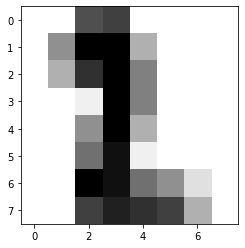

The label for this digit was: 2


In [10]:
digits = np.loadtxt('data/digits123.csv', delimiter=',', dtype=int)

def display_digit(i, digits):
    digit_sample = np.ones((8,8))*16 - np.reshape(digits[i, :-1], (8, 8))
    plt.imshow(digit_sample, cmap='gray', vmax=16)
    plt.show()
    print("The label for this digit was:", digits[i, -1])

display_digit(200, digits)

# Normalize the values of the pixels to be between 0 and 1
X = digits[:, :-1] / 16

# Generate one-hot encoding for Y
y = digits[:, -1]
Y = np.eye(y.max())[y - y.min()]

### Assignment 5

Define and train a neural network, called `digit_NN`, for the digit data set.

In [11]:
# Load the already backpropagated weights for the network

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, test_size = 0.3,  random_state=11)

# create network structure (taken from notebook form last week)
digit_NN = NN(layer_sizes = [64, 65, 3])

# train neural network
costs = optimize(digit_NN, X_train, Y_train, alpha = 0.001, iterations = 1000, desc = 'iteration')

def compute_accuracy(H, Y):
    return ((np.argmax(H, axis = 1) == np.argmax(Y, axis = 1))*1).mean()

# Compute the network outputs for the digits
digit_outputs = digit_NN.forward(X_test)

# print("\nThe network accuracy for these digits was:")
print(compute_accuracy(digit_outputs, Y_test))

0.9938650306748467


**Q6. Which configuration of layers gave you the best results?**

*I took the configuration of network from last week. This gives the best results with an alpha of 0.001 and iterations of 1000. This is the best because the accuracy is 1.0. So i'll leave it at that.*


### *Case 3: Iris*

As a last use-case, let's look at data you have seen before in a different context. You have used the Iris dataset in an unsupervised learning context. But you can also use supervised learning to achieve something similar. The Iris samples are categorized into three classes. We can use a neural network to classify the data based on those classes. Load the Iris data below, read the description of the data set, and check what the features and labeled classes correspond to.

In [12]:
from sklearn import datasets
iris = datasets.load_iris()

X_raw = iris.data
y_raw = iris.target

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

### Assignment 6a 

The data should be modified so that it can be used with a neural network.

First, you should normalize `X_raw`, i.e. make sure that all features are converted to values between 0 and 1. Store the result in a variable `X`.

*Hint:* Make sure to normalize each feature separately. What *Numpy* function could you use to compute all normalization constants at once?

In [13]:
# normalize each feature using np.linalg.norm
X = X_raw / (np.linalg.norm(X_raw))


### Assignment 6b

Second, the variable `y_raw` contains class data (values 0, 1, or 2). Transform this to one-hot encoding and store the result in a variable `Y`. 

*Hint:* Making good use of existing *Numpy* functions will save some time here. Specifically the [eye](https://numpy.org/doc/stable/reference/generated/numpy.eye.html) function and [index arrays](https://numpy.org/doc/stable/user/basics.indexing.html#index-arrays) might be useful.

In [14]:
# transform y_raw to one-hot-encoding
n_values = np.max(y_raw) + 1
Y = np.eye(n_values)[y_raw]


### Assignment 6c

Now split the data in a train and test set. Make sure that the train size is 70% and the test size is 30% of the data. You may use library functions to do this.

In [15]:
# split the data in a train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7, test_size = 0.3,  random_state=11)

### Assignment 6d

Finally create a neural network, train it on the train data, and compute the accuracy with the test data. It should be possible to get an accuracy above 90%.

You can use the function `plot_costs` to monitor the cost during the learning process.

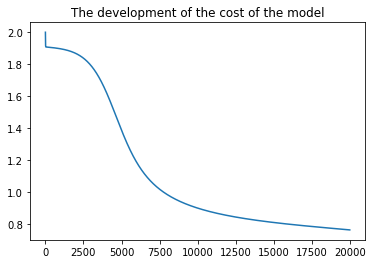

0.9333333333333333


In [16]:
# create network structure (taken from notebook form last week)
digit_NN = NN(layer_sizes = [4, 6, 3])

# train neural network
costs = optimize(digit_NN, X_train, Y_train, alpha = 0.002, iterations = 20000, desc = 'iteration')

# plot costs: enables the consideration elbow of curve
plot = plot_costs(costs)

def compute_accuracy(H, Y):
    return ((np.argmax(H, axis = 1) == np.argmax(Y, axis = 1))*1).mean()

# Compute the network outputs for the digits
digit_outputs = digit_NN.forward(X_test)

# print("\nThe network accuracy for these digits was:")
print(compute_accuracy(digit_outputs, Y_test))

## Final thoughts

Done! Let's have a final look at what you did. You've implemented `LogisticLayer` and `NN`. You essentially created a modular way for composing neural networks. Next module you will even expand more on this modularity.

We gave you the equations for working out the gradients. And you might be wondering where they came from. One of the subtle points that you might not have noticed is that this modular computation of the gradients is done by relying heavily on the application of the chain rule. Let's consider this with a 2 layer network using the non-vectorized maths ($w_1$ and $b_1$ are just scalar parameters). Then, the network is defined as:

$$
\begin{align}
a_1 = x &&
z_1 = w_1a_1+b_1 &&
a_2 = g(z_1) &&
z_2 = w_2a_2+b_2 &&
a_3 = g(z_2) &&
\hat{y} = a_3
\end{align} \\
l = -y\ln(\hat{y}) - (1 - y)\ln(1 - \hat{y})
$$

The loss of this network $l$ is the result of applying quite a few equations in order. Each of these equations can be seen as a function, and so, in order to compute $\frac{\partial l}{\partial w_1}$, we can use many applications of the chain rule to get:

$$
\frac{\partial l}{\partial w_1} = \frac{\partial l}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial a_3}\frac{\partial a_3}{\partial z_2}\frac{\partial z_2}{\partial a_2}\frac{\partial a_2}{\partial z_1}\frac{\partial z_1}{\partial w_1}
$$

In principle you could compute this whole derivative as one single expression, but it is already impractical and you can imagine how unwieldy this would get if you increase the number of layers. What we did is break it up. During the backpropagation every logistic layer computes the term $\frac{\partial l}{\partial a}$ for the previous layer. This no longer has to be worked out as part of the expression. So, starting with the last layer, the partial derivative w.r.t. the activation $a_3$ can be computed and the expression simplified: 

$$
\frac{\partial l}{\partial w_1} = \boxed{\frac{\partial l}{\partial \hat{y}}\frac{\partial \hat{y}}{\partial a_3}}\frac{\partial a_3}{\partial z_2}\frac{\partial z_2}{\partial a_2}\frac{\partial a_2}{\partial z_1}\frac{\partial z_1}{\partial w_1} = \boxed{\frac{\partial l}{\partial a_3}}\frac{\partial a_3}{\partial z_2}\frac{\partial z_2}{\partial a_2}\frac{\partial a_2}{\partial z_1}\frac{\partial z_1}{\partial w_1}
$$

Then we can use the computed $\frac{\partial l}{\partial a_3}$ and the activations at $a_2$ to further compute partial derivative w.r.t. $a_2$, resulting in:

$$
\frac{\partial l}{\partial w_1} = \boxed{\frac{\partial l}{\partial a_3}\frac{\partial a_3}{\partial z_2}\frac{\partial z_2}{\partial a_2}}\frac{\partial a_2}{\partial z_1}\frac{\partial z_1}{\partial w_1} = \boxed{\frac{\partial l}{\partial a_2}}\frac{\partial a_2}{\partial z_1}\frac{\partial z_1}{\partial w_1}
$$

The newly computed $\frac{\partial l}{\partial a_2}$ can then be used directly to compute the partial derivative w.r.t. $w_1$. The computation of the term $\frac{\partial l}{\partial a}$ at every layer is thus at the core of the backpropagation algorithm.

Returning to the full vectorized equations from the assignment, the equations that you got for computing $\frac{\partial l}{\partial W}$ were:

$$
\begin{align}
\frac{\partial l}{\partial W} = D^T \cdot A &&
D = A_{\mathrm{next}}\odot(1 \ominus A_{\mathrm{next}}) \odot \boxed{\frac{\partial l}{\partial A_{\mathrm{next}}}}
\end{align}
$$

are a vectorized version of working out:
$$
\frac{\partial l}{\partial w} = \boxed{\frac{\partial l}{\partial a_\mathrm{next}}}\frac{\partial a_\mathrm{next}}{\partial z}\frac{\partial z}{\partial w}
$$

So you've essentially been applying the chain rule at every step of the backpropagation algorithm.

You now understand the basis of any neural network. From here on you will learn tricks to speed up the learning, avoid local minimums, avoid overfitting, and other improvements, but you now know the fundaments on which those are built.